# Data
Data is located under [S3 bucket](https://registry.opendata.aws/spacenet/) for Spacenet (us-east-1 region), s3://spacenet-dataset/Urban_3D_Challenge/. Downloading requires you to download the AWS command line interface (CLI) and configuring it to your account credentials. Download speed is 8 MiB/s, downloading took ~20 mins. 

Our Train data is split between ground truth (GT) and Inputs. The GT files are instance level (GTI), ... (GTC), ...(GTL). The input files are Domain Surface Models including buildings (DSM), Domain Terrain Models of the ground and natural features not including buildings (DTM), and orthorectified satellite imagery (RGB). All input data is in GeoTIFF format (can click 2 open and view in any photo viewer)


In [105]:
!ls ../../Train/GT/*004_* 

../../Train/GT/JAX_Tile_004_GTC.tif  ../../Train/GT/TAM_Tile_004_GTC.tif
../../Train/GT/JAX_Tile_004_GTI.tif  ../../Train/GT/TAM_Tile_004_GTI.tif
../../Train/GT/JAX_Tile_004_GTL.tif  ../../Train/GT/TAM_Tile_004_GTL.tif


In [106]:
!ls ../../Train/Inputs/*004_*

../../Train/Inputs/JAX_Tile_004_DSM.tif
../../Train/Inputs/JAX_Tile_004_DTM.tif
../../Train/Inputs/JAX_Tile_004_RGB.tif
../../Train/Inputs/TAM_Tile_004_DSM.tif
../../Train/Inputs/TAM_Tile_004_DTM.tif
../../Train/Inputs/TAM_Tile_004_RGB.tif


### Size of Data
Training data

In [107]:
! du -d 1 -h ../../Train

7.5G	../../Train/Inputs
4.3G	../../Train/GT
12G	../../Train


* 7.5G allocated to inputs (RGB, DSM, DTM) for Training
* 4.3G allocated to masks & labels (GTI, GTC, GTL) for Testing

Test data

In [108]:
! du -d 1 -h ../../Test

2.7G	../../Test/Inputs
1.5G	../../Test/GT
4.2G	../../Test


* 2.7G allocated to the inputs (RGB, DSM, DTM) for Testing
* 1.5G allocated to masks & labels (GTI, GTC, GTL)

# Visualizing the Satellite Imagery

In [53]:
# Standard imports
import os
import numpy as np
import matplotlib.pyplot as plt
# GDAL import
from osgeo import gdal, osr
% matplotlib inline
# Reusing ALBU's code for easy dataset handling
from dataset.reading_image_provider import ReadingImageProvider
from dataset.urban3d_dem_image import TiffDemImageType
from dataset.tiff_image import TiffImageType

In [74]:
dataset_path = '../../Train/'
train_dir='Inputs/'
mask_dir='GT/'
paths = {
    'masks': mask_dir,
    'images': train_dir,
    'dems': train_dir,
    'dtms': train_dir,
}

fn_mapping = {
    'masks': lambda name: name.replace('RGB', 'GTI'), # mask filenames end in GTI
    'dems': lambda name: name.replace('RGB', 'DSM'), # dems = DSMs
    'dtms': lambda name: name.replace('RGB', 'DTM') # dtms = DTMs
}

paths = {k: os.path.join(dataset_path, v) for k,v in paths.items()}

# Create an indexable dataset of the images, without reading each image into memory
ds = ReadingImageProvider(TiffImageType, paths, fn_mapping,
            image_suffix='RGB'
)

### Getting lat-long coordinates

Each GDAL (TIFF) image actually contains metadata about its location according to some reference system. Lucky for us, the coordinate system used by the data curators is `WGS_84` which is the standard lat-long coordinate reference. We just need to trim away the unnecessary information by making this conversion explicit.

We write a function that returns another function that translates from the internal coordinate system of the photos (x,y) into lat long.

In [75]:
def make_latlong_transform(rip):
    """Takes a ReadingImageProvider & constructs the latlong 
    transform from it. Returns a function (x,y)-->(lat, long)"""
    tiff = rip[0]
    tiff.read_image()
    ds = tiff.src_ds
    old_cs = osr.SpatialReference()
    old_cs.ImportFromWkt(ds.GetProjectionRef())

    wgs84_wkt = """
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.01745329251994328,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]]"""
    new_cs = osr.SpatialReference()
    new_cs.ImportFromWkt(wgs84_wkt)
    transform = osr.CoordinateTransformation(old_cs, new_cs)

    def unpack(latlong):
        return latlong[1], latlong[0]
    
    return lambda x, y: unpack(transform.TransformPoint(x, y))

### Plotting Images

We want to be able to visualize images from the dataset. Here's where we use Albu's dataset code to make loading the images & preprocessing them very simple. We use his dataset object `ReadingImageProvider` to index our actual images, and then load the image (he wrote a class called `TiffImageType` to wrap our images) to plot. Lastly, we can take the bottom left point of the image to get the latitude & longitude of each picture.

In [109]:
def plot_random(rip, trans_fn):
    """Takes a ReadingImageProvider & randomly selects 1 photo 2 plot
    
    Source: https://stackoverflow.com/questions/2922532/obtain-latitude-and-longitude-from-a-geotiff-file
    """
    fig, ax = plt.subplots(figsize=(10,10))
    idx = np.random.randint(0, len(rip))
    tiff = rip[idx]
    ax.imshow(tiff.read_image())
    
    ds = tiff.src_ds
    width = ds.RasterXSize
    height = ds.RasterYSize
    # Get Coord System
    gt = ds.GetGeoTransform()
    # Get Bottom Left Coord
    minx = gt[0]
    miny = gt[3] + width*gt[4] + height *gt[5]
    ax.set_title("Lat: {:.6f}, Long: {:.6f}".format(*trans_fn(minx, miny)))
    return fig, ax


Here we instantiate the transformation from (x,y) of the internal picture coords to (lat, long) pairs. `trans` will take both an `x` and a `y` argument.

In [101]:
trans = make_latlong_transform(ds)

We pass in the transformation to put the lat & long coords with every plotted image.

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f96b0373780>)

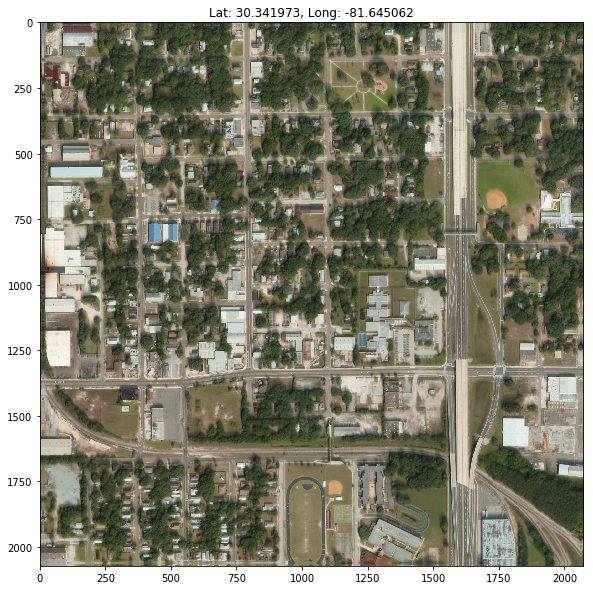

In [102]:
plot_random(ds, trans)